# Boredom Classifier

This notebook is designed to classify multi class images using transfer learning.

Pre trained models are currently:

- Xception
- InceptionV3
- EfficientNetB0
- MobileNetV2

It assumes images are organized into classification directoeries (e.g. e0, e1, e2, e3 for enagegement)

You need to provide image size and data store (e.g. extracted faces, or whole images)  

It will run Xception by default

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import class_weight

import time

from keras import layers 
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model

from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import RMSprop, SGD, Adam

from keras.applications import Xception, MobileNetV2
from keras.applications.inception_v3 import InceptionV3

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# create a data generator
def create_generator(data_dir, image_size, batch_size):
       
    train_data_dir = data_dir + 'train'
    validation_data_dir = data_dir + 'validation'

    datagen = ImageDataGenerator(rescale=1.0/255.0)
    
    
    train_generator = datagen.flow_from_directory(
    directory = train_data_dir,
    target_size = (image_size, image_size),
    batch_size = batch_size,
    class_mode= 'categorical')

    val_generator = datagen.flow_from_directory(
    directory = validation_data_dir,
    target_size = (image_size, image_size),
    batch_size = batch_size,
    class_mode= 'categorical')

    
    return train_generator, val_generator

In [5]:
def create_model(pre_trained, image_size, weights, epochs):

    # create the base pre-trained model, don't include classification layer
    base_model = pre_trained(input_shape = (image_size, image_size, 3),
                             include_top = False, 
                             weights = weights)

    # Freeze all layers (up to layer 100)
    #for layer in base_model.layers:
    for layer in base_model.layers[:126]: 
        layer.trainable = False

    # Add some layers    
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation='relu')(x)   
    x = layers.Dense(4, activation='softmax')(x)

    model = Model(inputs = base_model.input, outputs = x)

    return model

In [6]:
def run_model(model_dir, model_name, model, data_store, lr, decay):
    
    # checkpoint callback
    timestr = time.strftime("%Y%m%d-%H%M%S")
    best_model_file = model_dir + model_name + '_' + timestr + '_{epoch}.hdf5'

    checkpoint = ModelCheckpoint(best_model_file,
                                 monitor='accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 #save_weights_only=True,
                                 mode='max')

    # early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')   

    callbacks = [checkpoint, early_stopping]

    # compilation
    model.compile(optimizer=Adam(lr=lr),# decay=decay),
                  loss="categorical_crossentropy",
                  metrics =["accuracy"])

    # train
    history = model.fit_generator(
                train_generator,
    #           class_weight = class_weights,
                epochs=epochs,
                callbacks = callbacks,
                validation_data=val_generator)
    
    return history

In [7]:
# directory config (edit)
fps = '1FPS'
data_type = 'dataFacesAug' #'dataFacesAug' #'dataFacesAugStrat' #'dataFaces' #data
model_subdir = 'cnn'

# model config (select, sizes belong to models)
pre_trained_model, image_size, model_name = MobileNetV2, 224, 'MobileNetV2'
#pre_trained_model, image_size, model_name = Xception, 299, 'Xception'
#pre_trained_model, image_size, model_name = InceptionV3, 299, 'InceptionV3'
#pre_trained_model, image_size, model_name = EfficientNetB7, 224, 'EfficientNetB0'

# model hyper parameters (edit)
weights ='imagenet'
epochs = 100
batch_size = 32
lr = 0.0001
decay = 1e-6

# directory setup (don't edit)
data_dir =  '../../data/DAiSEE/' + fps + '/' + data_type + '/' 
model_dir = '../../data/models/' + model_subdir + '/'

# call the functions and run the model
train_generator, val_generator = create_generator(data_dir, image_size, batch_size)
model = create_model(pre_trained_model, image_size, weights, epochs)
model.summary()
history = run_model(model_dir, model_name, model, data_type, lr, decay)


Found 59765 images belonging to 4 classes.
Found 15537 images belonging to 4 classes.
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_

Epoch 1/100
1868/1868 [==============================] - ETA: 0s - loss: 0.8679 - accuracy: 0.6107
Epoch 00001: accuracy improved from -inf to 0.61069, saving model to ../../data/models/cnn/MobileNetV2_20201205-191236_1.hdf5
1868/1868 [==============================] - 108s 58ms/step - loss: 0.8679 - accuracy: 0.6107 - val_loss: 2.0782 - val_accuracy: 0.3165
Epoch 2/100
1867/1868 [============================>.] - ETA: 0s - loss: 0.6819 - accuracy: 0.6954
Epoch 00002: accuracy improved from 0.61069 to 0.69539, saving model to ../../data/models/cnn/MobileNetV2_20201205-191236_2.hdf5
1868/1868 [==============================] - 107s 57ms/step - loss: 0.6819 - accuracy: 0.6954 - val_loss: 1.7871 - val_accuracy: 0.3393
Epoch 3/100
1867/1868 [============================>.] - ETA: 0s - loss: 0.5478 - accuracy: 0.7591
Epoch 00003: accuracy improved from 0.69539 to 0.75907, saving model to ../../data/models/cnn/MobileNetV2_20201205-191236_3.hdf5
1868/1868 [==============================] - 10

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


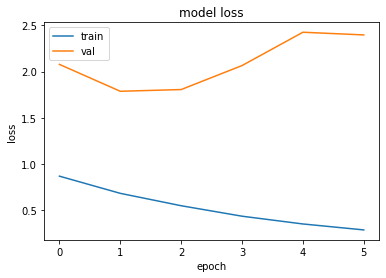

In [8]:
# Show graphs
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


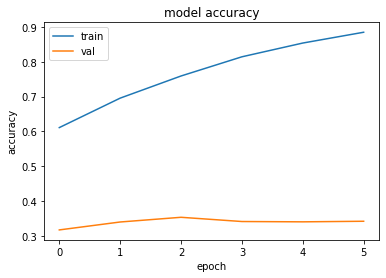

In [9]:
# Show graphs
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:
# create a data generator (using args from model trainig)

test_data_dir = data_dir + 'test'

test_datagen = ImageDataGenerator()

test_generator = datagen.flow_from_directory(
directory = test_data_dir,
target_size = (image_size, image_size),
batch_size = batch_size,
shuffle = False,
class_mode = 'categorical')
    

Found 20159 images belonging to 4 classes.


In [11]:
#from keras.models import load_model
#model = load_model('/host/efs/DAiSEE/models/dataFaces2/Xception_20201117-135852_5.hdf5')

In [12]:
class_labels = test_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(classes)

['b0', 'b1', 'b2', 'b3']


In [13]:
test_loss, test_acc = model.evaluate_generator(test_generator)
print('test acc:', test_acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.
test acc: 0.3676769733428955


## 

In [14]:
predictions = model.predict_generator(test_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [15]:
y_pred = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

print(class_labels)
print(confusion_matrix(test_generator.classes, y_pred))

report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

['b0', 'b1', 'b2', 'b3']
[[6194 1184  820   32]
 [4454  700  665   18]
 [2506  438  425    4]
 [1054  314 1258   93]]
             precision    recall  f1-score   support

         b0       0.44      0.75      0.55      8230
         b1       0.27      0.12      0.17      5837
         b2       0.13      0.13      0.13      3373
         b3       0.63      0.03      0.06      2719

avg / total       0.36      0.37      0.30     20159



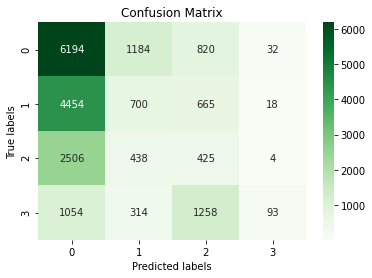

In [16]:
class_labels = [0,1,2,3]
cm = confusion_matrix(true_classes, y_pred, class_labels)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_labels); ax.yaxis.set_ticklabels(class_labels);